# Import Packages

In [10]:
import sys,os,pdb
import numpy as np
from astropy.table import Table, join, MaskedColumn
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy import wcs
import matplotlib.ticker
from astroquery.vizier import Vizier

# Define Functions

In [11]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t


def scale_asinh(img_input, scale_min=None, scale_max=None, non_linear=2.0):
	    
    """
    PURPOSE:    Scale image to look better in plotting

    INPUT:      img_input = image to scale (float arr)
                scale_min = lower bound of scaling (arr)
                scale_max = upper bound of scaling (arr)

    OUTPUT:     img = scaled image (float arr)

    """

    img = np.array(img_input, copy=True)
	
    if scale_min == None:
        scale_min = img.min()
    if scale_max == None:
        scale_max = img.max()
        
    factor = np.arcsinh((scale_max - scale_min)/non_linear)
    indices0 = np.where(img < scale_min)
    indices1 = np.where((img >= scale_min) & (img <= scale_max))
    indices2 = np.where(img > scale_max)
    img[indices0] = 0.0
    img[indices2] = 1.0
    img[indices1] = np.arcsinh((img[indices1] - scale_min)/non_linear)/factor

    return img


def sexa2deg(ra_sexa,de_sexa):

    ra_deg, de_deg = [], []
    for i, val in enumerate(ra_sexa):

        string = str(ra_sexa[i]) + ' ' + str(de_sexa[i])
        coords = SkyCoord(string, unit=(u.hourangle, u.deg))
        ra_deg.append(float("{0:.5f}".format(coords.ra.deg)))
        de_deg.append(float("{0:.5f}".format(coords.dec.deg)))

    return ra_deg, de_deg


def calc_sep_ob(ra, de):

    """
    PURPOSE:    Calculate project separation between object and SigmaOri system

    INPUT:      ra, de = RA, DE of object 1 in '[hr/deg] [min] [sec]' format (str)

    OUTPUT:     sep_arcsec = projected separation in arcseconds (float)
                sep_parsec = projected separation in parsecs (float)

    """

    ### DISTANCE AND COORDINATES OF SIGMA ORI SYSTEM
    dist_ob = 385.
    ra_ob, de_ob = 84.68658, -2.60003

    ### 2D & 3D COORDINATES FOR SIGMA ORI SYSTEM
    c2d_ob = SkyCoord(ra=ra_ob*u.degree, dec=de_ob*u.degree, frame='icrs')
    c3d_ob = SkyCoord(ra=ra_ob*u.degree, dec=de_ob*u.degree, distance=dist_ob*u.pc, frame='icrs')

    ### SEPARATION IN ARCSEC FROM 2D COORDINATES OF OBJECT
    coord = SkyCoord(str(ra)+' '+str(de), unit=(u.hourangle, u.deg))
    c2d = SkyCoord(ra=coord.ra, dec=coord.dec, frame='icrs')
    sep = c2d_ob.separation(c2d)

    ### SEPARATION IN PARSEC FROM 3D COORDINATES OF OBJECT
    c3d = SkyCoord(ra=coord.ra, dec=coord.dec, frame='icrs', distance=dist_ob*u.pc)
    dis = c3d_ob.separation_3d(c3d)
    
    return sep.arcsec, dis.pc  

# Code

Load in Sigma Orionis data

In [12]:
T = get_data("J/AJ/153/240")

Get projected separations from Sigma Orionis

In [13]:
Sep_AS, Sep_PC = [], []
for i, val in enumerate(T['__HHM2007_']):
    Sep_AS.append(calc_sep_ob(T['RAJ2000'][i], T['DEJ2000'][i])[0])
    Sep_PC.append(calc_sep_ob(T['RAJ2000'][i], T['DEJ2000'][i])[1])
T['Rp_AS'], T['Rp_PC'] = Sep_AS, Sep_PC

Setup and create plot

/opt/homebrew/lib/python3.9/site-packages/astropy/visualization/wcsaxes/formatter_locator.py:298: UserWarning: Spacing is too small - resetting spacing to match format
  warnings.warn("Spacing is too small - resetting spacing to match format")


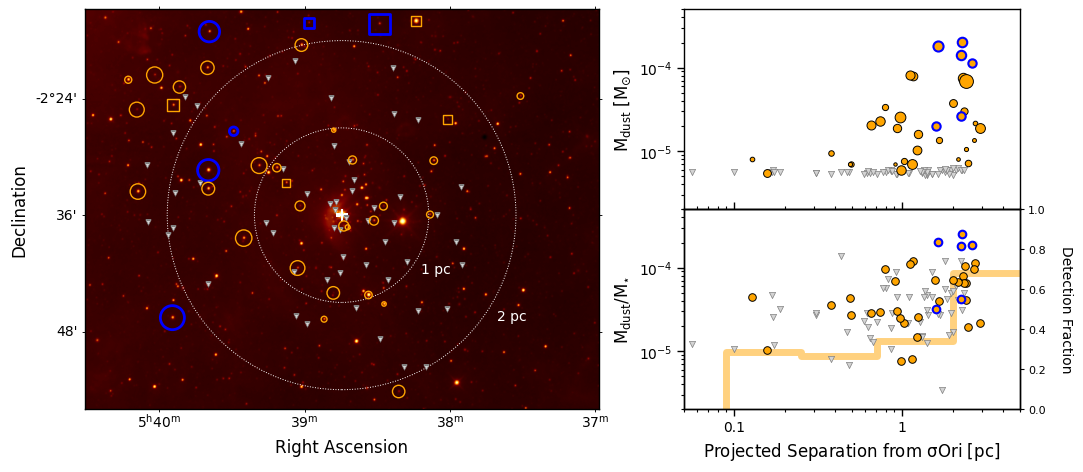

In [14]:
### SETUP PLOT
mpl.rc('xtick',labelsize=15)
mpl.rc('ytick',labelsize=15)
mpl.rc('xtick.major',size=2,pad=3,width=0.5)
mpl.rc('ytick.major',size=2,pad=3,width=0.5)
mpl.rc('axes',linewidth=1)
mpl.rc('lines',markersize=5)

### LOAD WISE IMAGE
Img_Wise, hdr = fits.getdata('../data/WISE_cube_2d.fits', header=True)
Img_Wise = scale_asinh(Img_Wise, scale_min=np.nanmin(Img_Wise) * 0.9, scale_max=np.nanmax(Img_Wise))
W = wcs.WCS(hdr)

### SETUP FIGURE WITH 3 PLOTS
fig = plt.figure(figsize=(12, 5))
ax  = fig.add_axes([0.05, 0.05, 0.45, 0.8], projection=W)
ax2 = fig.add_axes([0.56, 0.45, 0.28, 0.40])
ax3 = fig.add_axes([0.56, 0.05, 0.28, 0.40])
ax.set_xlim(300, Img_Wise.shape[1] - 300)
ax.set_ylim(583, Img_Wise.shape[0])

### SETUP WISE PLOT
ax.imshow(Img_Wise, origin='lower', cmap='afmhot')
ra = ax.coords['ra']
de = ax.coords['dec']
ra.set_axislabel('Right Ascension', fontsize=12)
de.set_axislabel('Declination', fontsize=12)
ra.set_ticks(spacing=0.2 * u.degree, exclude_overlapping=True)
de.set_ticks(spacing=0.2 * u.degree, exclude_overlapping=True)
ra.set_ticklabel(size=10)
de.set_ticklabel(size=10)
ra.set_major_formatter('hh:mm')
de.set_major_formatter('dd:mm')

### SETUP DUST MASS PLOT
ax2.tick_params(which='both', top=False, right=False, bottom=False, labelbottom=False, labelsize=10, length=2, color='k', width=0.8)
ax2.tick_params(which='major', axis='both', length=5, color='k', width=1)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\mathregular{M_{dust}}$' + ' ' + r'$\mathregular{[M_{\odot}]}$', fontsize=12)
ax2.set_xlim([0.05, 5])
ax2.set_ylim([2e-6, 5e-4])

### SET UP NORMALIZED DUST MASS PLOT
ax3.tick_params(which='both', top='off', right='off', labelsize=10, length=2, color='k', width=0.8)
ax3.tick_params(which='major', axis='both', length=5, color='k', width=1)
ax3.set_xlabel('Projected Separation from '+r'$\mathregular{\sigma Ori}$'+' [pc]', fontsize=12)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylabel(r'$\mathregular{M_{dust}/M_{\star}}$', fontsize=12)
ax3.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax3.set_xlim([0.05, 5])
ax3.set_ylim([2e-6, 5e-4])

### SET UP RIGHT AXIS WITH DETECTION FRACTION
ax4 = ax3.twinx()
ax4.set_ylabel('Detection Fraction', rotation=270, labelpad=20, fontsize=10)
ax4.tick_params(which='both', labelsize=8, length=3, color='k', width=0.8)
ax4.set_xlim([0.05, 5])
ax4.set_ylim([0.0, 1.0])
ax3.set_zorder(ax4.get_zorder() + 1)
ax3.patch.set_visible(False)

### PLOT SIGMA ORI & DISTANCE CIRCLES OVER WISE IMAGE
ax.scatter(84.68658, -2.60003, marker='+', s=80, c='white', zorder=1, linewidth=1.5, transform=ax.get_transform('fk5'))
circ1 = plt.Circle((84.68658, -2.60), radius=0.15, color='white', fill=False, linewidth=0.7, linestyle='dotted', transform=ax.get_transform('fk5'))
circ2 = plt.Circle((84.68658, -2.60), radius=0.30, color='white', fill=False, linewidth=0.7, linestyle='dotted', transform=ax.get_transform('fk5'))
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.text(84.55, -2.70, '1 pc', color='white', fontsize=10, transform=ax.get_transform('fk5'))
ax.text(84.42, -2.78, '2 pc', color='white', fontsize=10, transform=ax.get_transform('fk5'))

### MAKE FLAGS AND DO SOME CALCULATIONS FOR PLOTTING VARIABLES
GasDet = np.array([1153, 540, 1274, 1152, 818, 1075]) ### GAS DETECTIONS
TD = np.array([1268, 1267, 908, 897, 818, 540, 411, 299]) ### TRANSITION DISKS 
T.add_column(MaskedColumn(name='Detected', data=T['F1.33']/T['e_F1.33'] >= 2.9)) ### NON-DETECTIONS
T['RA_deg'], T['DE_deg'] = sexa2deg(T['RAJ2000'], T['DEJ2000']) ### CONVERTING COORDINATES TO DEGREES
T['fMdust'] = T['Mdust'] * (const.M_earth.cgs.value / const.M_sun.cgs.value) / T['Mass'] ### FRACTIONAL DUST MASS
T['fMdust'][np.where(~T['Detected'])] = 3.0 * np.copy(T['e_Mdust'][np.where(~T['Detected'])] * (const.M_earth.cgs.value / const.M_sun.cgs.value)) / T['Mass'][np.where(~T['Detected'])]

### PLOT NON-DETECTIONS
ax.scatter(T['RA_deg'][np.where(~T['Detected'])], T['DE_deg'][np.where(~T['Detected'])], s=15, marker='v', 
           facecolor='lightgray', edgecolor='gray', zorder=2, linewidth=0.5, transform=ax.get_transform('fk5'))
ax2.scatter(T['Rp_PC'][np.where(~T['Detected'])], 3.0 * T['e_Mdust'][np.where(~T['Detected'])] * (const.M_earth.cgs.value / const.M_sun.cgs.value) , 
            s=20, marker='v', facecolor='lightgray', edgecolor='gray', zorder=10, linewidth=0.5)
ax3.scatter(T['Rp_PC'][np.where(~T['Detected'])], T['fMdust'][np.where(~T['Detected'])], 
            marker='v', facecolor='lightgray', s=20, edgecolor='gray', linewidth=0.5, zorder=10)

### PLOT DETECTIONS
for i, t in enumerate(T[np.where(T['Detected'])]):

    MarkerSize, MarkerSize2 = np.round(300*(t['fMdust']/np.max(T['fMdust']))), np.round(100*(t['Mass']/np.max(T['Mass'])))
    MarkerShape, EdgeColor, EdgeColor2, LineWidth, LineWidth2, Zorder = 'o', 'orange', 'black', 1, 0.7, 50

    if (t['__HHM2007_'] in TD):
        MarkerShape = 's'
    if (t['__HHM2007_'] in GasDet):
        EdgeColor, EdgeColor2, LineWidth, LineWidth2, Zorder = 'blue', 'blue', 2, 1.5, 100

    ax.scatter(t['RA_deg'], t['DE_deg'], s=MarkerSize, marker=MarkerShape, facecolor='none', edgecolor=EdgeColor, 
               zorder=3, linewidth=LineWidth, transform=ax.get_transform('fk5'))
    ax2.scatter(t['Rp_PC'], t['Mdust'] * (const.M_earth.cgs.value / const.M_sun.cgs.value), 
                s=MarkerSize2, marker='o', facecolor='orange', edgecolor=EdgeColor2, linewidth=LineWidth2, zorder=Zorder)
    ax3.scatter(t['Rp_PC'], t['fMdust'], marker='o', facecolor='orange', s=30, edgecolor=EdgeColor2, linewidth=LineWidth2, zorder=Zorder)

### PLOT DETECTION FRACTION
bins_edges = np.logspace(-1.5, 0.75, 6)
fdet = []
for i in np.arange(len(bins_edges)-1):
    ind = np.where( (T['Rp_PC'] <= bins_edges[i + 1]) & (T['Rp_PC'] >  bins_edges[i]) )
    n_nd = len(set(np.where(~T['Detected'])[0]).intersection(ind[0]))
    n_sd = len(ind[0]) - n_nd
    fdet = np.append(fdet, 1.0 * n_sd / len(ind[0]))
ax4.step(bins_edges[1:], fdet, linewidth=5, color='orange', zorder=1, alpha=0.5)
ax3.set_zorder(ax4.get_zorder() + 1)
ax3.patch.set_visible(False)

Save figure

In [15]:
plt.savefig('../output/figure_06.png',bbox_inches='tight',dpi=900)
plt.close('all')